## Sheet 5 - Practical Part

In [1]:
import pickle
from pathlib import Path
from time import time
from collections import namedtuple
from itertools import repeat
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
class TrainProgressBar:
    def __init__(self, num_runs, num_epochs, num_batches):
        self._runs_bar = tqdm(total=num_runs, desc="runs") if num_runs > 1 else None
        self._epoch_bar = tqdm(total=num_epochs, desc="epochs")
        self._batch_bar = tqdm(total=num_batches, desc="batches")
        
    @staticmethod
    def _decorate_iterator(it, pbar):
        try:
            pbar.reset(total=len(it))
        except TypeError:
            pbar.reset()
        
        for item in it:
            yield item
            pbar.update(1)
            
    def runs(self, iterator):
        if self._runs_bar:
            yield from TrainProgressBar._decorate_iterator(iterator, self._runs_bar)
        else:
            yield from iterator
        
    def epochs(self, iterator):
        yield from TrainProgressBar._decorate_iterator(iterator, self._epoch_bar)
        
    def batches(self, iterator):
        yield from TrainProgressBar._decorate_iterator(iterator, self._batch_bar)
        
    def write(self, text):
        self._batch_bar.write(text)
        
    def close(self):
        if self._runs_bar:
            self._runs_bar.close()
        self._epoch_bar.close()
        self._batch_bar.close()
        
    def __enter__(self):
        return self
    
    def __exit__(self, *exc):
        self.close()

In [3]:
class CIFAR10Dataset:
    def __init__(self, dataset='train', path='.'):
        path = Path(path)
        if dataset == 'train':
            batches = [self.load_batch(p) for p in path.glob('data_batch_*')]
            self.images = torch.cat([b for b, _ in batches])
            self.labels = torch.cat([b for _, b in batches])
        elif dataset == 'test':
            self.images, self.labels = self.load_batch(path / 'test_batch')
            
        # normalize
        self.images = self.images.float()
        self.labels = self.labels.long()
        
        std, mean = torch.std_mean(self.images, dim=0)
        self.images = (self.images - mean) / std
        
        assert len(self.images) == len(self.labels)
    
    def load_batch(self, path):
        with open(path, 'rb') as file:
            data_dict = pickle.load(file, encoding='bytes')
        images = data_dict[b'data'].reshape((-1, 32, 32, 3), order='F').swapaxes(1,2)
        images = torch.from_numpy(images)
        labels = torch.Tensor(data_dict[b'labels'])
        return images, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

In [4]:
class CUDADataLoader(DataLoader):
    def __iter__(self):
        for images, labels in super(CUDADataLoader, self).__iter__():
            yield [images.to('cuda:0'), labels.to('cuda:0')]

In [5]:
train_dataloader = CUDADataLoader(CIFAR10Dataset('train', '../data/cifar_10'),
                                  batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = CUDADataLoader(CIFAR10Dataset('test', '../data/cifar_10'),
                                  batch_size=64, shuffle=False, pin_memory=True)

In [6]:
def predictions_to_hits(predictions, labels):
    return predictions.argmax(dim=1).eq(labels).count_nonzero()

def train(model, optimizer, train_dataloader, test_dataloader=None,
          loss_fn=None, reg_fn=None, num_epochs=25, pbar=None):
    
    # init outputs and progressbar
    
    losses = torch.zeros(num_epochs)
    train_accuracies = torch.zeros(num_epochs)
    test_accuracies = torch.zeros(num_epochs)
    
    for epoch in pbar.epochs(range(num_epochs)):
        
        # init variables
        
        epoch_losses = torch.zeros(len(train_dataloader)).to("cuda:0")
        hits = torch.zeros(1).to("cuda:0")
        total = torch.zeros(1).to("cuda:0")
        
        # train model
        
        model.train(True)
        
        for i, (images, labels) in enumerate(pbar.batches(train_dataloader)):
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            
            if(reg_fn):
                loss += reg_fn()
            
            loss.backward()
            optimizer.step()
            
            epoch_losses[i] = loss
            hits += predictions_to_hits(predictions, labels)
            total += len(images)
        
        losses[epoch] = torch.mean(epoch_losses)
        train_accuracies[epoch] = hits / total
        
        # get test accuracy
        
        model.train(False)
        
        if test_dataloader is not None:
            hits[:] = total[:] = 0
            for images, labels in pbar.batches(test_dataloader):
                predictions = model(images)
                hits += predictions_to_hits(predictions, labels)
                total += len(images)
            
        test_accuracies[epoch] = hits / total
        
        # update pbar
        
        pbar.write(f"[{epoch+1:>2}/{num_epochs}] "
                   f"train_accuracy: {train_accuracies[epoch]:.4f}, "
                   f"test_accuracy: {test_accuracies[epoch]:.4f}, "
                   f"loss: {losses[epoch]:.4f}")
    
    return tuple(a.detach().numpy() for a in (losses, train_accuracies, test_accuracies))

In [7]:
Results = namedtuple("Results", "losses train_accuracies test_accuracies")

def plot_results(names, results):
    _, axs = plt.subplots(1,2,figsize=(14,7))
    
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')
    
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('accuracy')
    
    for name, result in zip(names, results):
        a, *_ = axs[0].plot(result.losses, label=name)
        axs[1].plot(result.test_accuracies, label=name, color=a.get_color())
        #axs[1].plot(result.train_accuracies, label=name, color=a.get_color(), linestyle='dashed')

    axs[0].legend()
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


In [8]:
def make_model():
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 32 * 3, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    ).to('cuda:0')

def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95))

In [9]:
results = dict()

---

### baseline model

In [10]:
model = make_model()
optimizer = make_optimizer(model)

with TrainProgressBar(1, 25, 782) as pbar:
    results["baseline"] = Results(*train(model, optimizer, train_dataloader, test_dataloader,
                                         loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

[ 1/25] train_accuracy: 0.4231, test_accuracy: 0.4769, loss: 1.6257
[ 2/25] train_accuracy: 0.5086, test_accuracy: 0.5107, loss: 1.4019
[ 3/25] train_accuracy: 0.5485, test_accuracy: 0.5154, loss: 1.2809
[ 4/25] train_accuracy: 0.5841, test_accuracy: 0.5308, loss: 1.1792
[ 5/25] train_accuracy: 0.6138, test_accuracy: 0.5257, loss: 1.0918
[ 6/25] train_accuracy: 0.6452, test_accuracy: 0.5326, loss: 1.0047
[ 7/25] train_accuracy: 0.6745, test_accuracy: 0.5369, loss: 0.9186
[ 8/25] train_accuracy: 0.7057, test_accuracy: 0.5341, loss: 0.8344
[ 9/25] train_accuracy: 0.7317, test_accuracy: 0.5305, loss: 0.7619
[10/25] train_accuracy: 0.7568, test_accuracy: 0.5336, loss: 0.6854
[11/25] train_accuracy: 0.7813, test_accuracy: 0.5347, loss: 0.6226
[12/25] train_accuracy: 0.8003, test_accuracy: 0.5389, loss: 0.5663
[13/25] train_accuracy: 0.8198, test_accuracy: 0.5323, loss: 0.5170
[14/25] train_accuracy: 0.8359, test_accuracy: 0.5299, loss: 0.4677
[15/25] train_accuracy: 0.8449, test_accuracy: 0

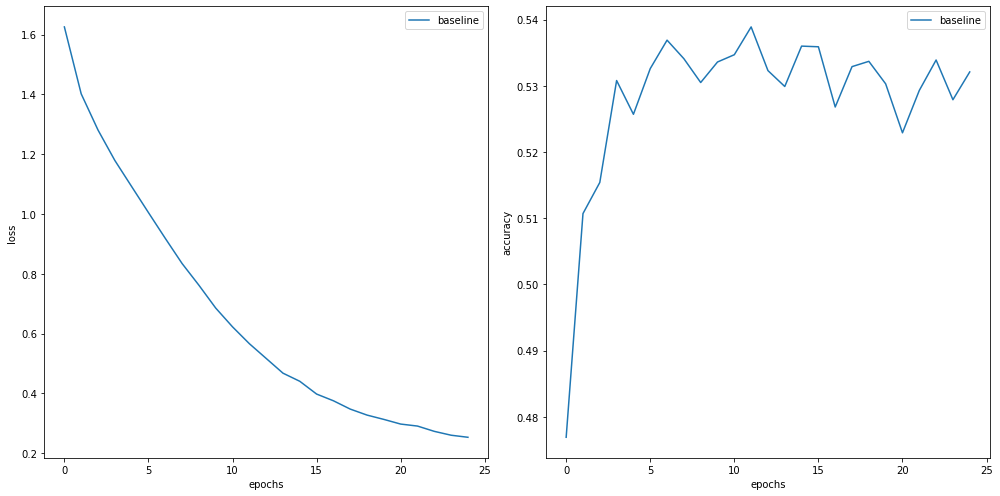

In [11]:
plot_results(['baseline'], [results['baseline']])

---

### orthogonal matrix regularization

In [12]:
class OrthogonalRegularizer(nn.Module):
    def __init__(self, model, lamb):
        super(OrthogonalRegularizer, self).__init__()
        self.weights = [p for n, p in model.named_parameters() if n.endswith("weight")]
        self.lamb = lamb
    
    def forward(self, x=None):
        products = [w.t().matmul(w) for w in self.weights]
        norms = torch.Tensor([torch.norm(p)**2 - 2 * p.trace() + p.shape[0] for p in products])
        return self.lamb * norms.sum()


lambdas = 10 ** -(3 + 7 * torch.rand(4)) #[1e-7, 1e-8, 1e-9, 1e-10]

with TrainProgressBar(4, 25, 782) as pbar:
    for lamb in pbar.runs(lambdas):
        name = f'orthogonal lr={lamb:.0e}'
        pbar.write(f" +++ {name} +++")
        model = make_model()
        optimizer = make_optimizer(model)
        results[name] = Results(*train(model, optimizer, train_dataloader, test_dataloader,
                                       loss_fn=F.cross_entropy, reg_fn=OrthogonalRegularizer(model, lamb),
                                       num_epochs=25, pbar=pbar))

 +++ orthogonal lr=1e-08 +++
[ 1/25] train_accuracy: 0.4290, test_accuracy: 0.4765, loss: 1.6207
[ 2/25] train_accuracy: 0.5039, test_accuracy: 0.4997, loss: 1.4057
[ 3/25] train_accuracy: 0.5478, test_accuracy: 0.5157, loss: 1.2846
[ 4/25] train_accuracy: 0.5854, test_accuracy: 0.5313, loss: 1.1773
[ 5/25] train_accuracy: 0.6178, test_accuracy: 0.5363, loss: 1.0836
[ 6/25] train_accuracy: 0.6498, test_accuracy: 0.5291, loss: 0.9977
[ 7/25] train_accuracy: 0.6772, test_accuracy: 0.5387, loss: 0.9106
[ 8/25] train_accuracy: 0.7056, test_accuracy: 0.5347, loss: 0.8307
[ 9/25] train_accuracy: 0.7324, test_accuracy: 0.5384, loss: 0.7575
[10/25] train_accuracy: 0.7581, test_accuracy: 0.5356, loss: 0.6838
[11/25] train_accuracy: 0.7825, test_accuracy: 0.5362, loss: 0.6176
[12/25] train_accuracy: 0.8029, test_accuracy: 0.5436, loss: 0.5604
[13/25] train_accuracy: 0.8203, test_accuracy: 0.5285, loss: 0.5153
[14/25] train_accuracy: 0.8345, test_accuracy: 0.5315, loss: 0.4733
[15/25] train_accur

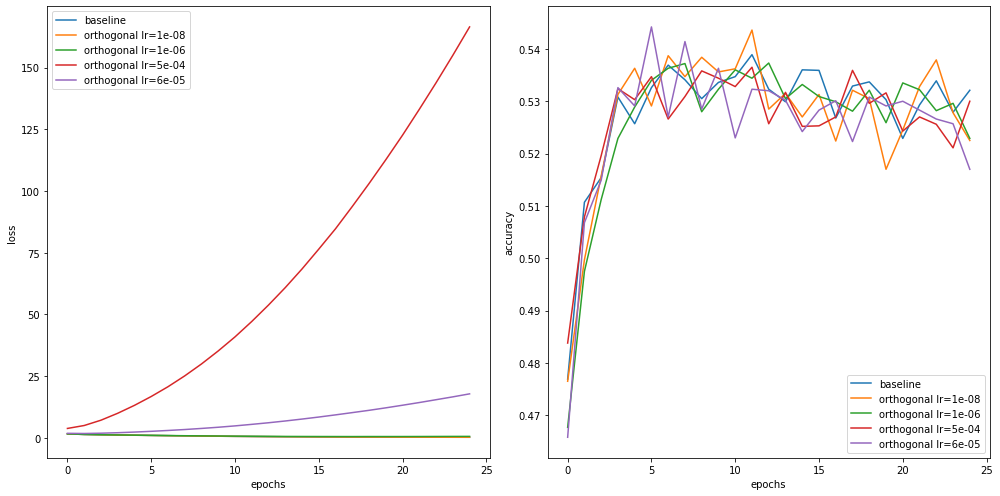

In [13]:
names = ["baseline"] + [n for n in results if n.startswith("orthogonal")]
plot_results(names, [results[n] for n in names])

---

### label smoothing

In [22]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, eps):
        super(LabelSmoothingLoss, self).__init__()
        self.eps = eps
    
    def forward(self, predictions, targets):
        log_p = F.log_softmax(predictions, dim=-1)
        noise_term = -log_p.mean() / predictions.shape[-1]
        return (1-self.eps) * F.nll_loss(log_p, targets) + self.eps * noise_term
    
epsilons = [5e-1, 1e-1, 1e-2, 1e-3] #10**-(2*torch.rand(4))

with TrainProgressBar(4, 25, 782) as pbar:
    for eps in pbar.runs(epsilons):
        name = f'label-smoothed lr={eps:.0e}'
        pbar.write(f" +++ {name} +++")
        model = make_model()
        optimizer = make_optimizer(model)
        results[name] = Results(*train(model, optimizer, train_dataloader, test_dataloader,
                                       loss_fn=LabelSmoothingLoss(eps), num_epochs=25, pbar=pbar))

 +++ label-smoothed* lr=5e-01 +++
[ 1/25] train_accuracy: 0.4243, test_accuracy: 0.4869, loss: 0.9677
[ 2/25] train_accuracy: 0.5086, test_accuracy: 0.5042, loss: 0.8721
[ 3/25] train_accuracy: 0.5543, test_accuracy: 0.5311, loss: 0.8220
[ 4/25] train_accuracy: 0.5900, test_accuracy: 0.5250, loss: 0.7795
[ 5/25] train_accuracy: 0.6216, test_accuracy: 0.5303, loss: 0.7443
[ 6/25] train_accuracy: 0.6515, test_accuracy: 0.5392, loss: 0.7079
[ 7/25] train_accuracy: 0.6848, test_accuracy: 0.5335, loss: 0.6731
[ 8/25] train_accuracy: 0.7136, test_accuracy: 0.5417, loss: 0.6411
[ 9/25] train_accuracy: 0.7407, test_accuracy: 0.5454, loss: 0.6112
[10/25] train_accuracy: 0.7698, test_accuracy: 0.5356, loss: 0.5838
[11/25] train_accuracy: 0.7945, test_accuracy: 0.5381, loss: 0.5557
[12/25] train_accuracy: 0.8142, test_accuracy: 0.5394, loss: 0.5335
[13/25] train_accuracy: 0.8359, test_accuracy: 0.5289, loss: 0.5130
[14/25] train_accuracy: 0.8537, test_accuracy: 0.5292, loss: 0.4938
[15/25] train_

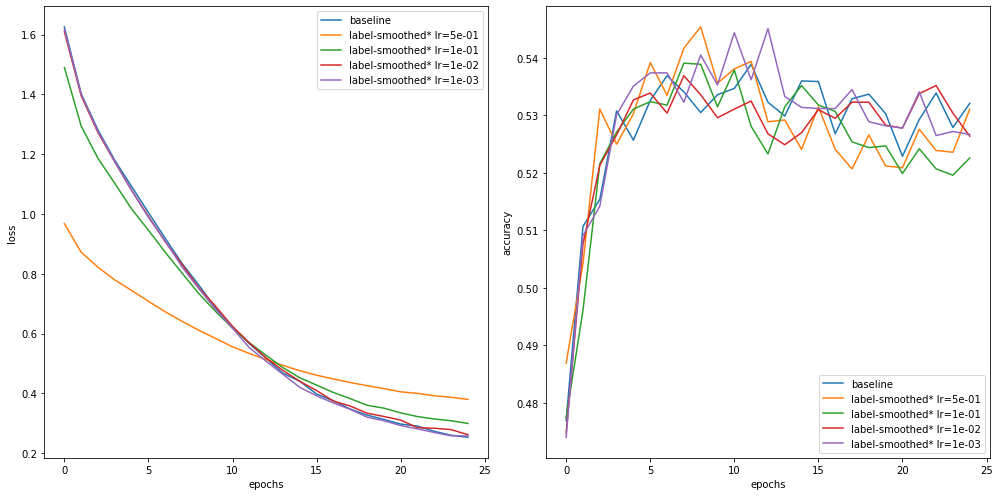

In [23]:
names = ["baseline"] + [n for n in results if n.startswith("label-smoothed")]
plot_results(names, [results[n] for n in names])

---

### batch normalization

In [16]:
def make_bn_model(bn_factory):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 32 * 3, 512),
        bn_factory(512),
        nn.ReLU(),
        nn.Linear(512, 512),
        bn_factory(512),
        nn.ReLU(),
        nn.Linear(512, 10),
        bn_factory(10)
    ).to('cuda:0')

bn_parameters = [dict(affine=False, track_running_stats=False),
                 dict(affine=False, momentum=None), dict(affine=True, momentum=None),
                 dict(affine=False, momentum=0.1),  dict(affine=True, momentum=0.1),
                 dict(affine=False, momentum=0.5),  dict(affine=True, momentum=0.5)]

names = ["bn batch-only"] + [f"bn affine={d['affine']}, m={d['momentum']}" for d in bn_parameters[1:]]

with TrainProgressBar(len(names), 25, 782) as pbar:
    for name, bn_params in pbar.runs(zip(names, bn_parameters)):
        pbar.write(f" +++ {name} +++")
        
        model = make_bn_model(partial(nn.BatchNorm1d, **bn_params))
        optimizer = make_optimizer(model)
                      
        results[name] = Results(*train(model, optimizer, train_dataloader, test_dataloader,
                                       loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

 +++ bn batch-only +++
[ 1/25] train_accuracy: 0.4299, test_accuracy: 0.4794, loss: 1.6359
[ 2/25] train_accuracy: 0.5066, test_accuracy: 0.5093, loss: 1.4568
[ 3/25] train_accuracy: 0.5488, test_accuracy: 0.5181, loss: 1.3680
[ 4/25] train_accuracy: 0.5771, test_accuracy: 0.5234, loss: 1.3063
[ 5/25] train_accuracy: 0.6025, test_accuracy: 0.5397, loss: 1.2532
[ 6/25] train_accuracy: 0.6285, test_accuracy: 0.5388, loss: 1.2051
[ 7/25] train_accuracy: 0.6494, test_accuracy: 0.5439, loss: 1.1604
[ 8/25] train_accuracy: 0.6718, test_accuracy: 0.5465, loss: 1.1205
[ 9/25] train_accuracy: 0.6949, test_accuracy: 0.5552, loss: 1.0801
[10/25] train_accuracy: 0.7150, test_accuracy: 0.5532, loss: 1.0417
[11/25] train_accuracy: 0.7345, test_accuracy: 0.5558, loss: 1.0069
[12/25] train_accuracy: 0.7506, test_accuracy: 0.5537, loss: 0.9768
[13/25] train_accuracy: 0.7698, test_accuracy: 0.5535, loss: 0.9479
[14/25] train_accuracy: 0.7894, test_accuracy: 0.5523, loss: 0.9149
[15/25] train_accuracy: 0

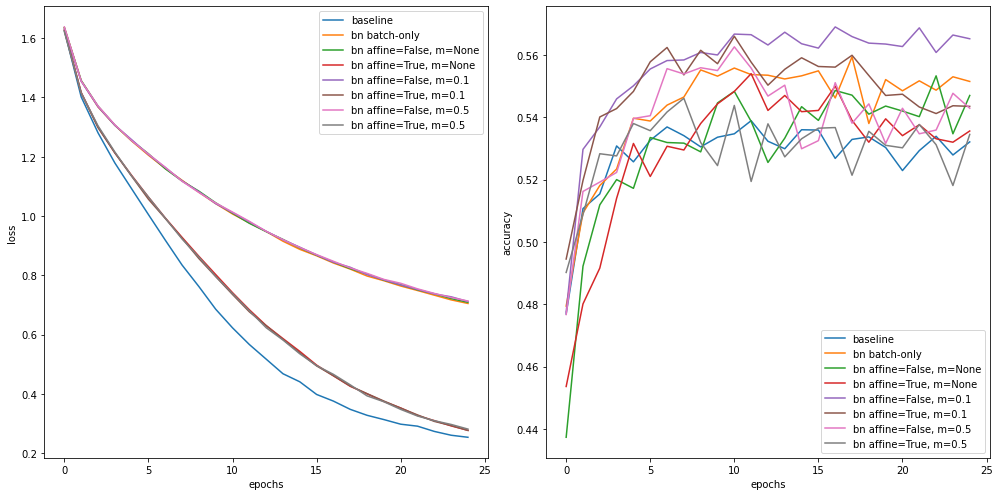

In [17]:
names = ["baseline"] + [n for n in results if n.startswith("bn")]
plot_results(names, [results[n] for n in names])